In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
#import kagglehub
#paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')
#awsaf49_pneumonia_chest_xray_npy_path = kagglehub.dataset_download('awsaf49/pneumonia-chest-xray-npy')

#print('Data source import complete.')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/MendeleyData


Mounted at /content/drive
/content/drive/MyDrive/MendeleyData


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/MendeleyData/train'
test_dir = '/content/drive/MyDrive/MendeleyData/test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    color_mode='grayscale',   # importante para que CovXNet funcione con (128,128,1)
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
!pip install -q covxnet --no-deps

In [5]:
from covxnet import CovXNet128

# CREACIÓN Y COMPILACIÓN DEL MODELO
model = CovXNet128(input_shape=(128, 128, 1), num_classes=1)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [6]:
# CALLBACKS
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model

def get_callbacks():
    callback1 = ModelCheckpoint('covxnet128.h5', monitor='val_accuracy',
                                verbose=1, save_best_only=True, mode='max')
    callback2 = CSVLogger('covxnet128_log.csv')
    return [callback1, callback2]

In [7]:
# ENTRENAMIENTO
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator,
    callbacks=get_callbacks()
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7426 - loss: 0.3973 
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to covxnet128.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 2094s 12s/step - accuracy: 0.7426 - loss: 0.3968 - val_accuracy: 0.6250 - val_loss: 0.9378
Epoch 2/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7341 - loss: 0.2219
Epoch 2: val_accuracy did not improve from 0.62500
164/164 ━━━━━━━━━━━━━━━━━━━━ 76s 463ms/step - accuracy: 0.7341 - loss: 0.2218 - val_accuracy: 0.6250 - val_loss: 1.3356
Epoch 3/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7403 - loss: 0.1877
Epoch 3: val_accuracy did not improve from 0.62500
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 459ms/step - accuracy: 0.7403 - loss: 0.1877 - val_accuracy: 0.6250 - val_loss: 1.2614
Epoch 4/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7409 - loss: 0.1486
Epoch 4: val_accuracy did not improve from 0.62500
164/164 ━━━━━━━━━━━━━━━━━━━━ 87s 493ms/step - accuracy: 0.7409 - loss: 0.1486 - val_accuracy: 0.6250 - val_loss: 2.0564
Epoch 5/25
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7432 - loss: 0.1358
Epoch 5: val_ac

In [8]:
# EVALUACIÓN
best_model = load_model('covxnet128.h5')
loss, acc = best_model.evaluate(test_generator)
print(f"Mejor modelo - Accuracy: {acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step - accuracy: 0.2984 - loss: 1.6654
Mejor modelo - Accuracy: 0.6250


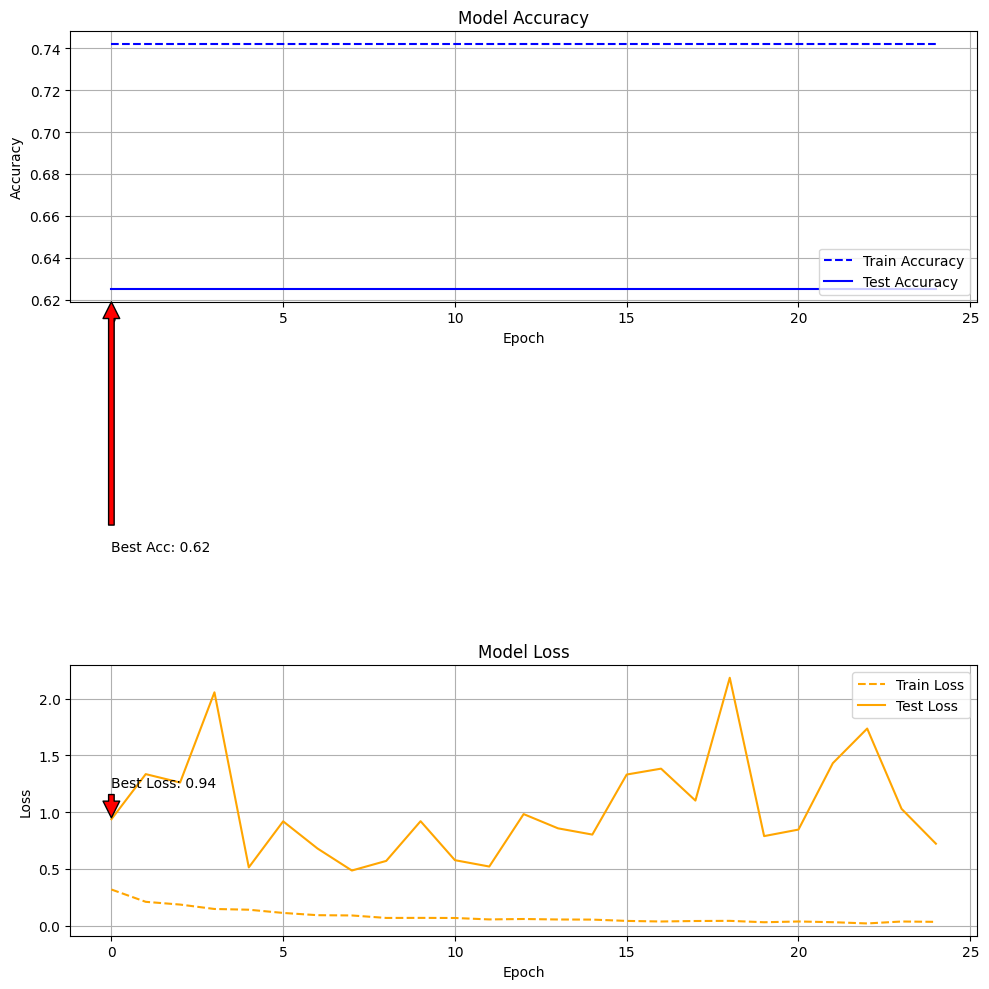

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='dashed')
axs[0].plot(history.history['val_accuracy'], label='Test Accuracy', color='blue')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].grid(True)

max_val_acc = np.max(history.history['val_accuracy'])
max_val_acc_epoch = np.argmax(history.history['val_accuracy'])
axs[0].annotate(f'Best Acc: {max_val_acc:.2f}',
                xy=(max_val_acc_epoch, max_val_acc),
                xytext=(max_val_acc_epoch*0.8, max_val_acc*0.8),
                arrowprops=dict(facecolor='red', shrink=0.05))

# Plot training & validation loss values
axs[1].plot(history.history['loss'], label='Train Loss', color='orange', linestyle='dashed')
axs[1].plot(history.history['val_loss'], label='Test Loss', color='orange')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].grid(True)

min_val_loss = history.history['val_loss'][max_val_acc_epoch]
min_val_loss_epoch = max_val_acc_epoch
axs[1].annotate(f'Best Loss: {min_val_loss:.2f}',
                xy=(min_val_loss_epoch, min_val_loss),
                xytext=(min_val_loss_epoch*0.8, min_val_loss*1.3),
                arrowprops=dict(facecolor='red', shrink=0.05))

fig.tight_layout()
plt.show()